### Import necessary packages

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(readxl)
library(httr)
library(jsonlite)
library(ggplot2)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

## Preliminary Exploratory Data Analysis

#### Download Pulsar Data
Below, we show that the pulsar data can be downloaded from the internet and extracted into a dataset.

In [2]:
# Download Pulsar data without kaggle helpers
PULSAR_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
GET(PULSAR_URL, write_disk(tf <- tempfile(fileext = ".zip")))

# Unzip the tempfile and read the csv inside it, renaming the columns as below
# then mutate the target class to a meaningful value for a human and convert to a factor
pulsar_data <- read_csv(unz(tf, "HTRU_2.csv"), col_names = c("mean_ip", 
                                                             "std_ip", 
                                                             "excess_kurtosis_ip", 
                                                             "skewness_ip", 
                                                             "mean_dm_snr", 
                                                             "std_dm_snr", 
                                                             "excess_kurtosis_dm_snr", 
                                                             "skewness_dm_snr", 
                                                             "target_class")) %>% 
                 mutate(target_class = as_factor(case_when(
                                                target_class == 1 ~ "pulsar",
                                                TRUE ~ "rf_noise")))  # serves the same purpose as a default case in a switch statement 
# unlink/remove the temporary file
unlink(tf)

# preview the data
pulsar_data %>% head(5)

Response [https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip]
  Date: 2021-07-23 15:42
  Status: 200
  Content-Type: application/x-httpd-php
  Size: 1.56 MB
<ON DISK>  /tmp/Rtmp5g51yf/file1c27a4126fc.zipNULL

Parsed with column specification:
cols(
  mean_ip = col_double(),
  std_ip = col_double(),
  excess_kurtosis_ip = col_double(),
  skewness_ip = col_double(),
  mean_dm_snr = col_double(),
  std_dm_snr = col_double(),
  excess_kurtosis_dm_snr = col_double(),
  skewness_dm_snr = col_double(),
  target_class = col_double()
)



mean_ip,std_ip,excess_kurtosis_ip,skewness_ip,mean_dm_snr,std_dm_snr,excess_kurtosis_dm_snr,skewness_dm_snr,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,rf_noise
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,rf_noise
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,rf_noise
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,rf_noise
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,rf_noise


### Raw data summary
Next, we split the data into a training (80% of the dataset) and a test (20% of the dataset), then join it back together with a new boolean column named `is_training`

#### Split the unscaled data into training (80%) and testing (20%) subsets

In [3]:
set.seed(1) # set the random seed so that sample_frac selects the same rows each run
pulsar_training <- pulsar_data %>% 
                    sample_frac(0.8) %>% 
                    mutate(is_training = TRUE)

# use dplyr's anti_join to maintain data exclusivity between the test and training subsets
pulsar_testing <- anti_join(pulsar_data, pulsar_training) %>%  # anti-join by all
                    mutate(is_training = FALSE)

pulsar_data_split_label <- full_join(pulsar_training, pulsar_testing)
pulsar_data_split_label %>% head(5)

Joining, by = c("mean_ip", "std_ip", "excess_kurtosis_ip", "skewness_ip", "mean_dm_snr", "std_dm_snr", "excess_kurtosis_dm_snr", "skewness_dm_snr", "target_class")

Joining, by = c("mean_ip", "std_ip", "excess_kurtosis_ip", "skewness_ip", "mean_dm_snr", "std_dm_snr", "excess_kurtosis_dm_snr", "skewness_dm_snr", "target_class", "is_training")



mean_ip,std_ip,excess_kurtosis_ip,skewness_ip,mean_dm_snr,std_dm_snr,excess_kurtosis_dm_snr,skewness_dm_snr,target_class,is_training
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
110.05469,44.63223,0.05861050,0.3322166,0.9749164,13.11951,15.929933,271.541301,rf_noise,TRUE
34.76562,29.01090,4.91407092,30.4824432,34.3294314,61.62832,1.964003,3.079504,pulsar,TRUE
137.64844,39.39575,0.08902873,0.6243448,1.9222408,16.18997,10.724031,127.252087,rf_noise,TRUE
113.91406,43.83653,0.17636968,0.5704354,1.1304348,11.69075,14.600849,254.798564,rf_noise,TRUE
134.21094,56.06715,-0.41452663,-0.6145839,160.1647157,33.58154,-1.462512,3.137146,rf_noise,TRUE


#### Summary stats of the unscaled pulsar data

In [4]:
sample_fraction = 0.8

min_df <- pulsar_data_split_label %>% 
            filter(is_training) %>% 
            select(-target_class, -is_training) %>% 
            map_df(c(min, max, mean))
max_df <- pulsar_data_split_label %>%
            filter(is_training) %>% 
            sample_frac(sample_fraction) %>% 
            select(-target_class, -is_training) %>% 
            map_df(max)
mean_df <- pulsar_data_split_label %>%
            filter(is_training) %>% 
            select(-target_class, -is_training) %>% 
            map_df(mean)
sd_df <- pulsar_data_split_label %>%
            filter(is_training) %>% 
            select(-target_class, -is_training) %>% 
            map_df(sd)
var_df <- pulsar_data_split_label %>%
            filter(is_training) %>% 
            select(-target_class, -is_training) %>% 
            map_df(var)

# get a vector of all the columns to join by
join_cols = colnames(pulsar_data_split_label %>% select(-target_class, -is_training))

# join the stats tables together
stats_table <- full_join(min_df, max_df, by=join_cols) %>% 
                full_join(., mean_df, by=join_cols) %>% 
                    full_join(., var_df, by=join_cols) %>% 
                        full_join(., sd_df, by=join_cols) %>% 
                mutate(stat_type = c("min", "max", "mean", "st_dev", "var")) %>% 
                relocate(stat_type)

print("Unscaled Training Data Statistics Summary")
stats_table

[1] "Unscaled Training Data Statistics Summary"


stat_type,mean_ip,std_ip,excess_kurtosis_ip,skewness_ip,mean_dm_snr,std_dm_snr,excess_kurtosis_dm_snr,skewness_dm_snr
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
min,5.81250,24.772042,-1.8760112,-1.791886,0.2132107,7.370432,-2.812353,-1.976976
max,192.61719,91.808628,8.0695220,68.101622,223.3921405,109.712649,34.539844,1191.000837
mean,111.11621,46.557176,0.4791296,1.782420,12.5160135,26.283099,8.315808,105.001481
st_dev,657.83650,46.826469,1.1429886,38.905369,854.0926704,377.704943,20.231942,11149.097738
var,25.64832,6.842987,1.0691065,6.237417,29.2248639,19.434633,4.497993,105.589288


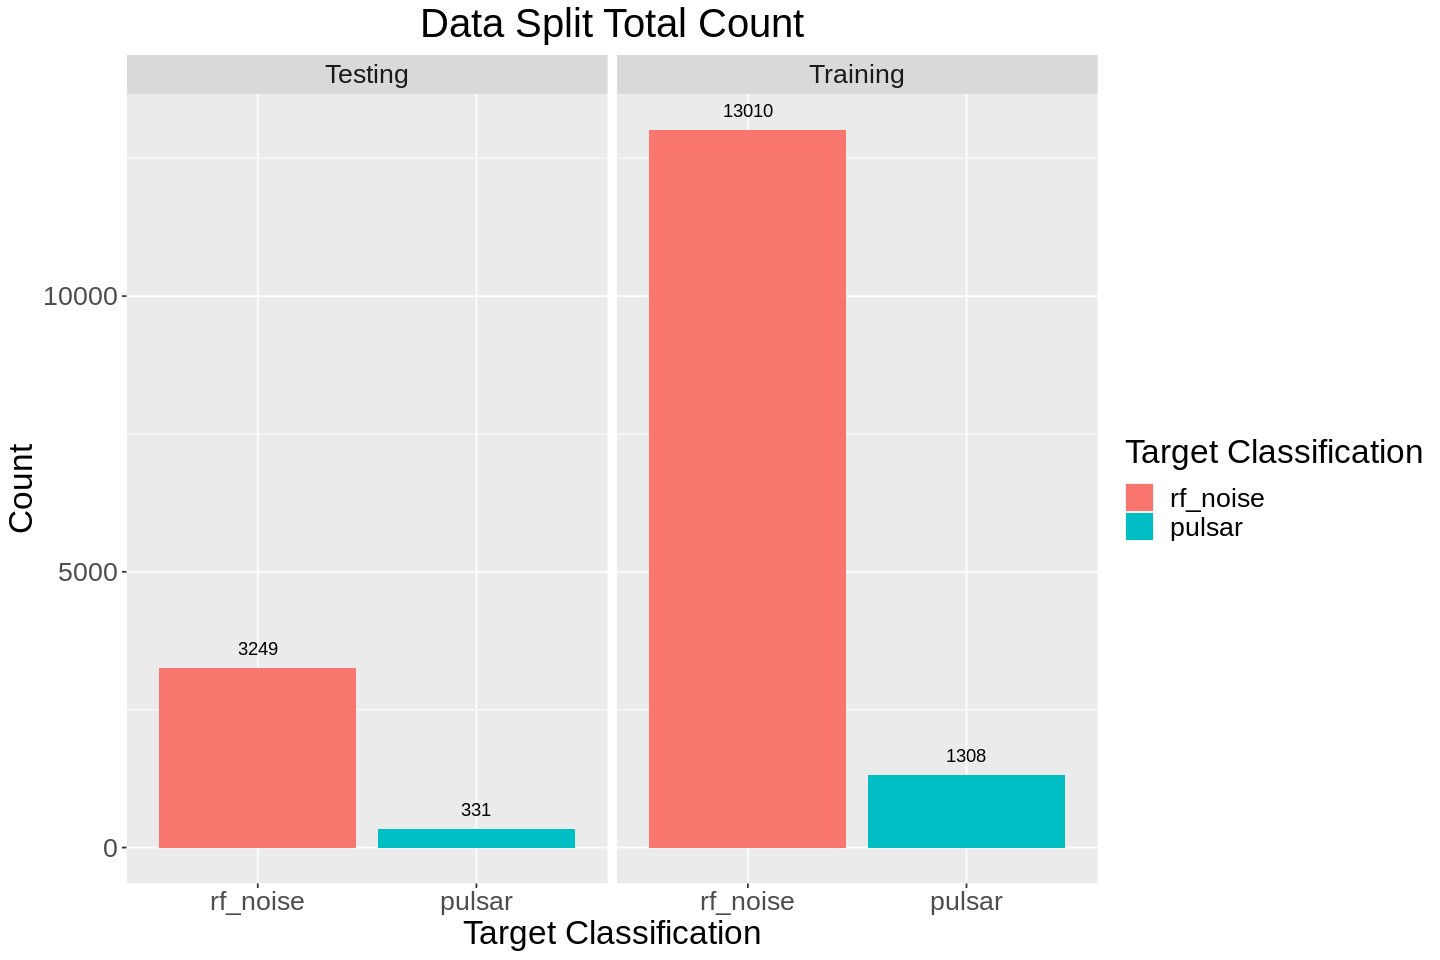

In [5]:
options(repr.plot.width = 12, repr.plot.height = 8)
training_bar_plot <- pulsar_data_split_label %>% 
                        ggplot(aes(x = target_class, fill = target_class)) + 
                            geom_bar() +
                            labs(x = "Target Classification", 
                                 y = "Count",
                                 fill = "Target Classification") +
                            geom_text(stat='count', aes(label=..count..), vjust = -1) +
                            ggtitle("Data Split Total Count") +
                            theme(text = element_text(size=20),
                                  plot.title = element_text(hjust = 0.5)) +
                        facet_wrap(~ is_training,
                                   labeller = labeller(is_training = c("TRUE" = "Training", "FALSE" = "Testing")))
training_bar_plot

#### Processing Recipe

In [6]:
pulsar_recipe <- recipe(target_class ~ mean_ip + std_ip + excess_kurtosis_ip + skewness_ip + std_dm_snr, data = pulsar_data_split_label) %>% 
                    na.omit() %>% 
                    step_center(all_predictors()) %>% 
                    step_scale(all_predictors())

# for comparison; possibly removed in final doc
pulsar_recipe_all <- recipe(target_class ~ mean_ip + std_ip + excess_kurtosis_ip + skewness_ip +
                                           mean_dm_snr + std_dm_snr + excess_kurtosis_dm_snr + skewness_dm_snr, 
                                           data = pulsar_data_split_label) %>% 
                    na.omit() %>% 
                    step_scale(all_predictors()) %>% 
                    step_center(all_predictors())

pulsar_scaled <- pulsar_recipe %>% 
                    prep() %>% 
                    bake(pulsar_data_split_label %>% filter(is_training))
# for comparison; possibly removed in final doc
pulsar_scaled_all <- pulsar_recipe_all %>% 
                    prep() %>% 
                    bake(pulsar_data_split_label %>% filter(is_training))

pulsar_scaled %>%  head(5)


mean_ip,std_ip,excess_kurtosis_ip,skewness_ip,std_dm_snr,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-0.03996739,-0.2801764,-0.3940142,-0.2331522,-0.6783061,rf_noise
-2.97487762,-2.5629317,4.1692181,4.6550856,1.8130853,pulsar
1.03568924,-1.0453876,-0.3654267,-0.1857896,-0.5206084,rf_noise
0.11047836,-0.3964533,-0.2833424,-0.1945299,-0.7516864,rf_noise
0.90168898,1.3908168,-0.8386754,-0.3866564,0.3726147,rf_noise


#### Exploratory Plotting
The pair plot below highlights the relationships and distributions of the five chosen variables which will be used as predictors of the target class

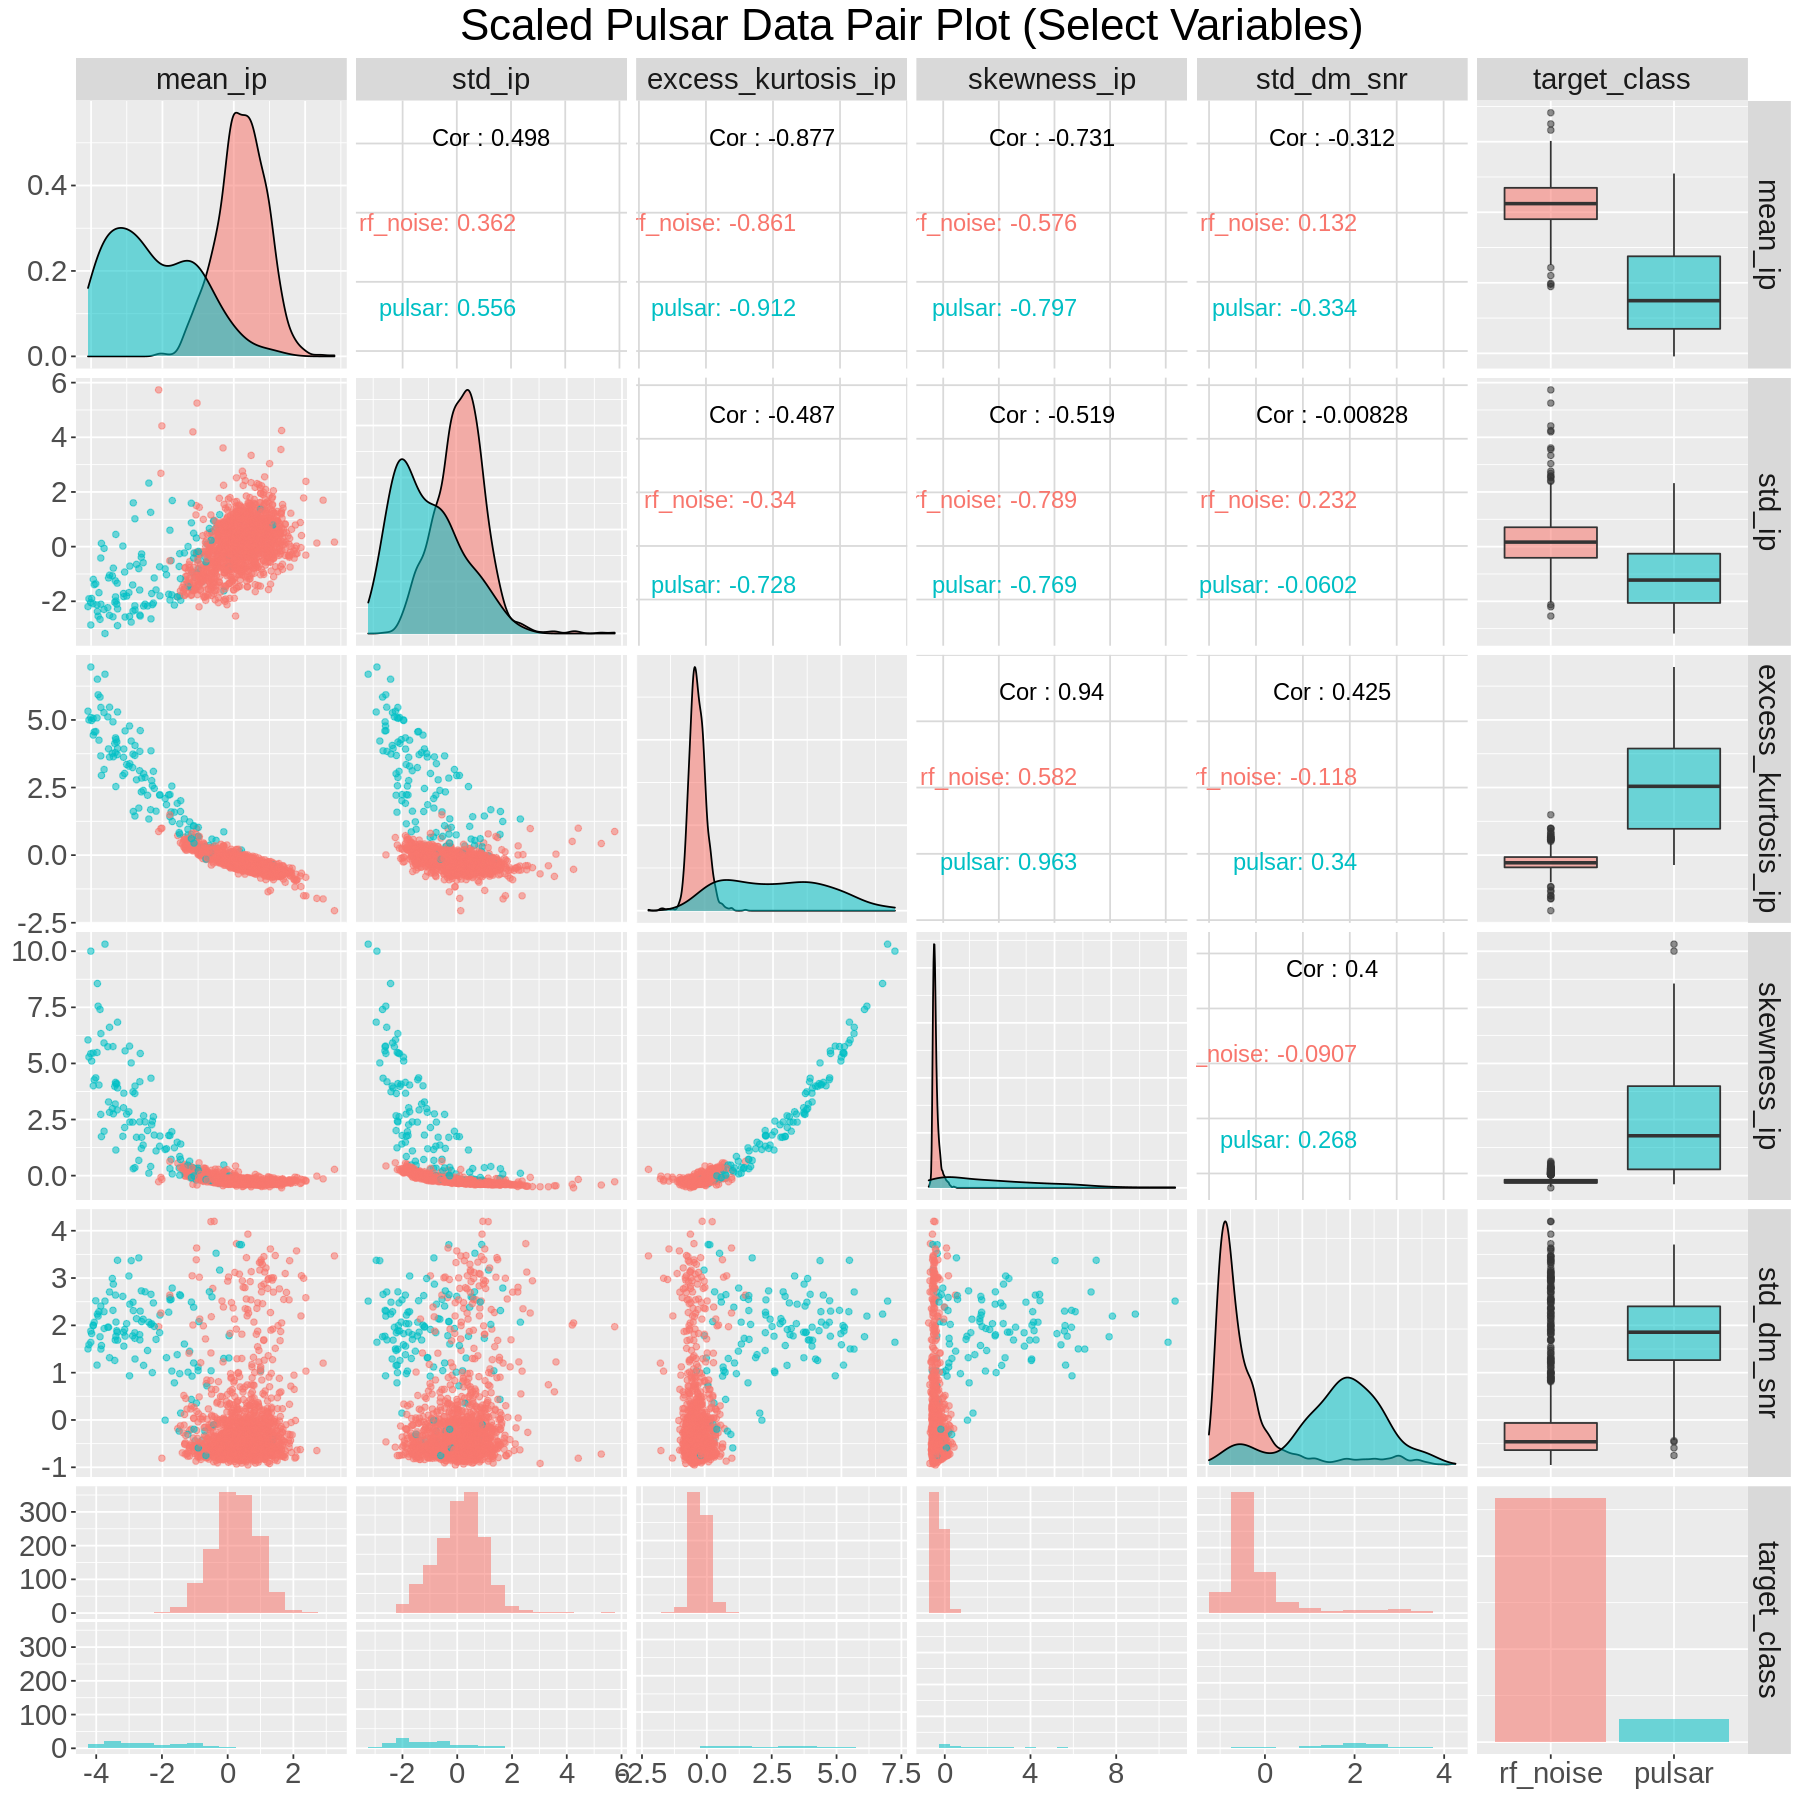

In [7]:
options(repr.plot.width = 15, repr.plot.height = 15)

# subset of the data for plotting
pulsar_scaled_subset <- pulsar_scaled %>% sample_frac(0.1) 

ggpairs(pulsar_scaled_subset,
           mapping = aes(color=target_class, alpha = 0.3),
           lower=list(combo=wrap("facethist", binwidth=0.5)),
           upper=list(continuous = wrap("cor", size=5))) +
        ggtitle("Scaled Pulsar Data Pair Plot (Select Variables)") +
        theme(text = element_text(size = 22),
              plot.title = element_text(hjust = 0.5))
        

#### Plotting of all possible predictors (unscaled) for temporary comparison

In [1]:
options(repr.plot.width = 15, repr.plot.height = 15)
ggpairs(pulsar_training %>% sample_frac(0.2),
           mapping = aes(color=target_class, alpha = 0.3),
           lower=list(combo=wrap("facethist", binwidth=0.5)),
           upper=list(continuous = wrap("cor", size=5))) +
        ggtitle("Scaled Pulsar Data Pair Plot All") +
        theme(text = element_text(size = 17),
              plot.title = element_text(hjust = 0.5))

ERROR: Error in ggpairs(pulsar_training %>% sample_frac(0.2), mapping = aes(color = target_class, : could not find function "ggpairs"


#### Plotting of all possible predictors (scaled) for temporary comparison

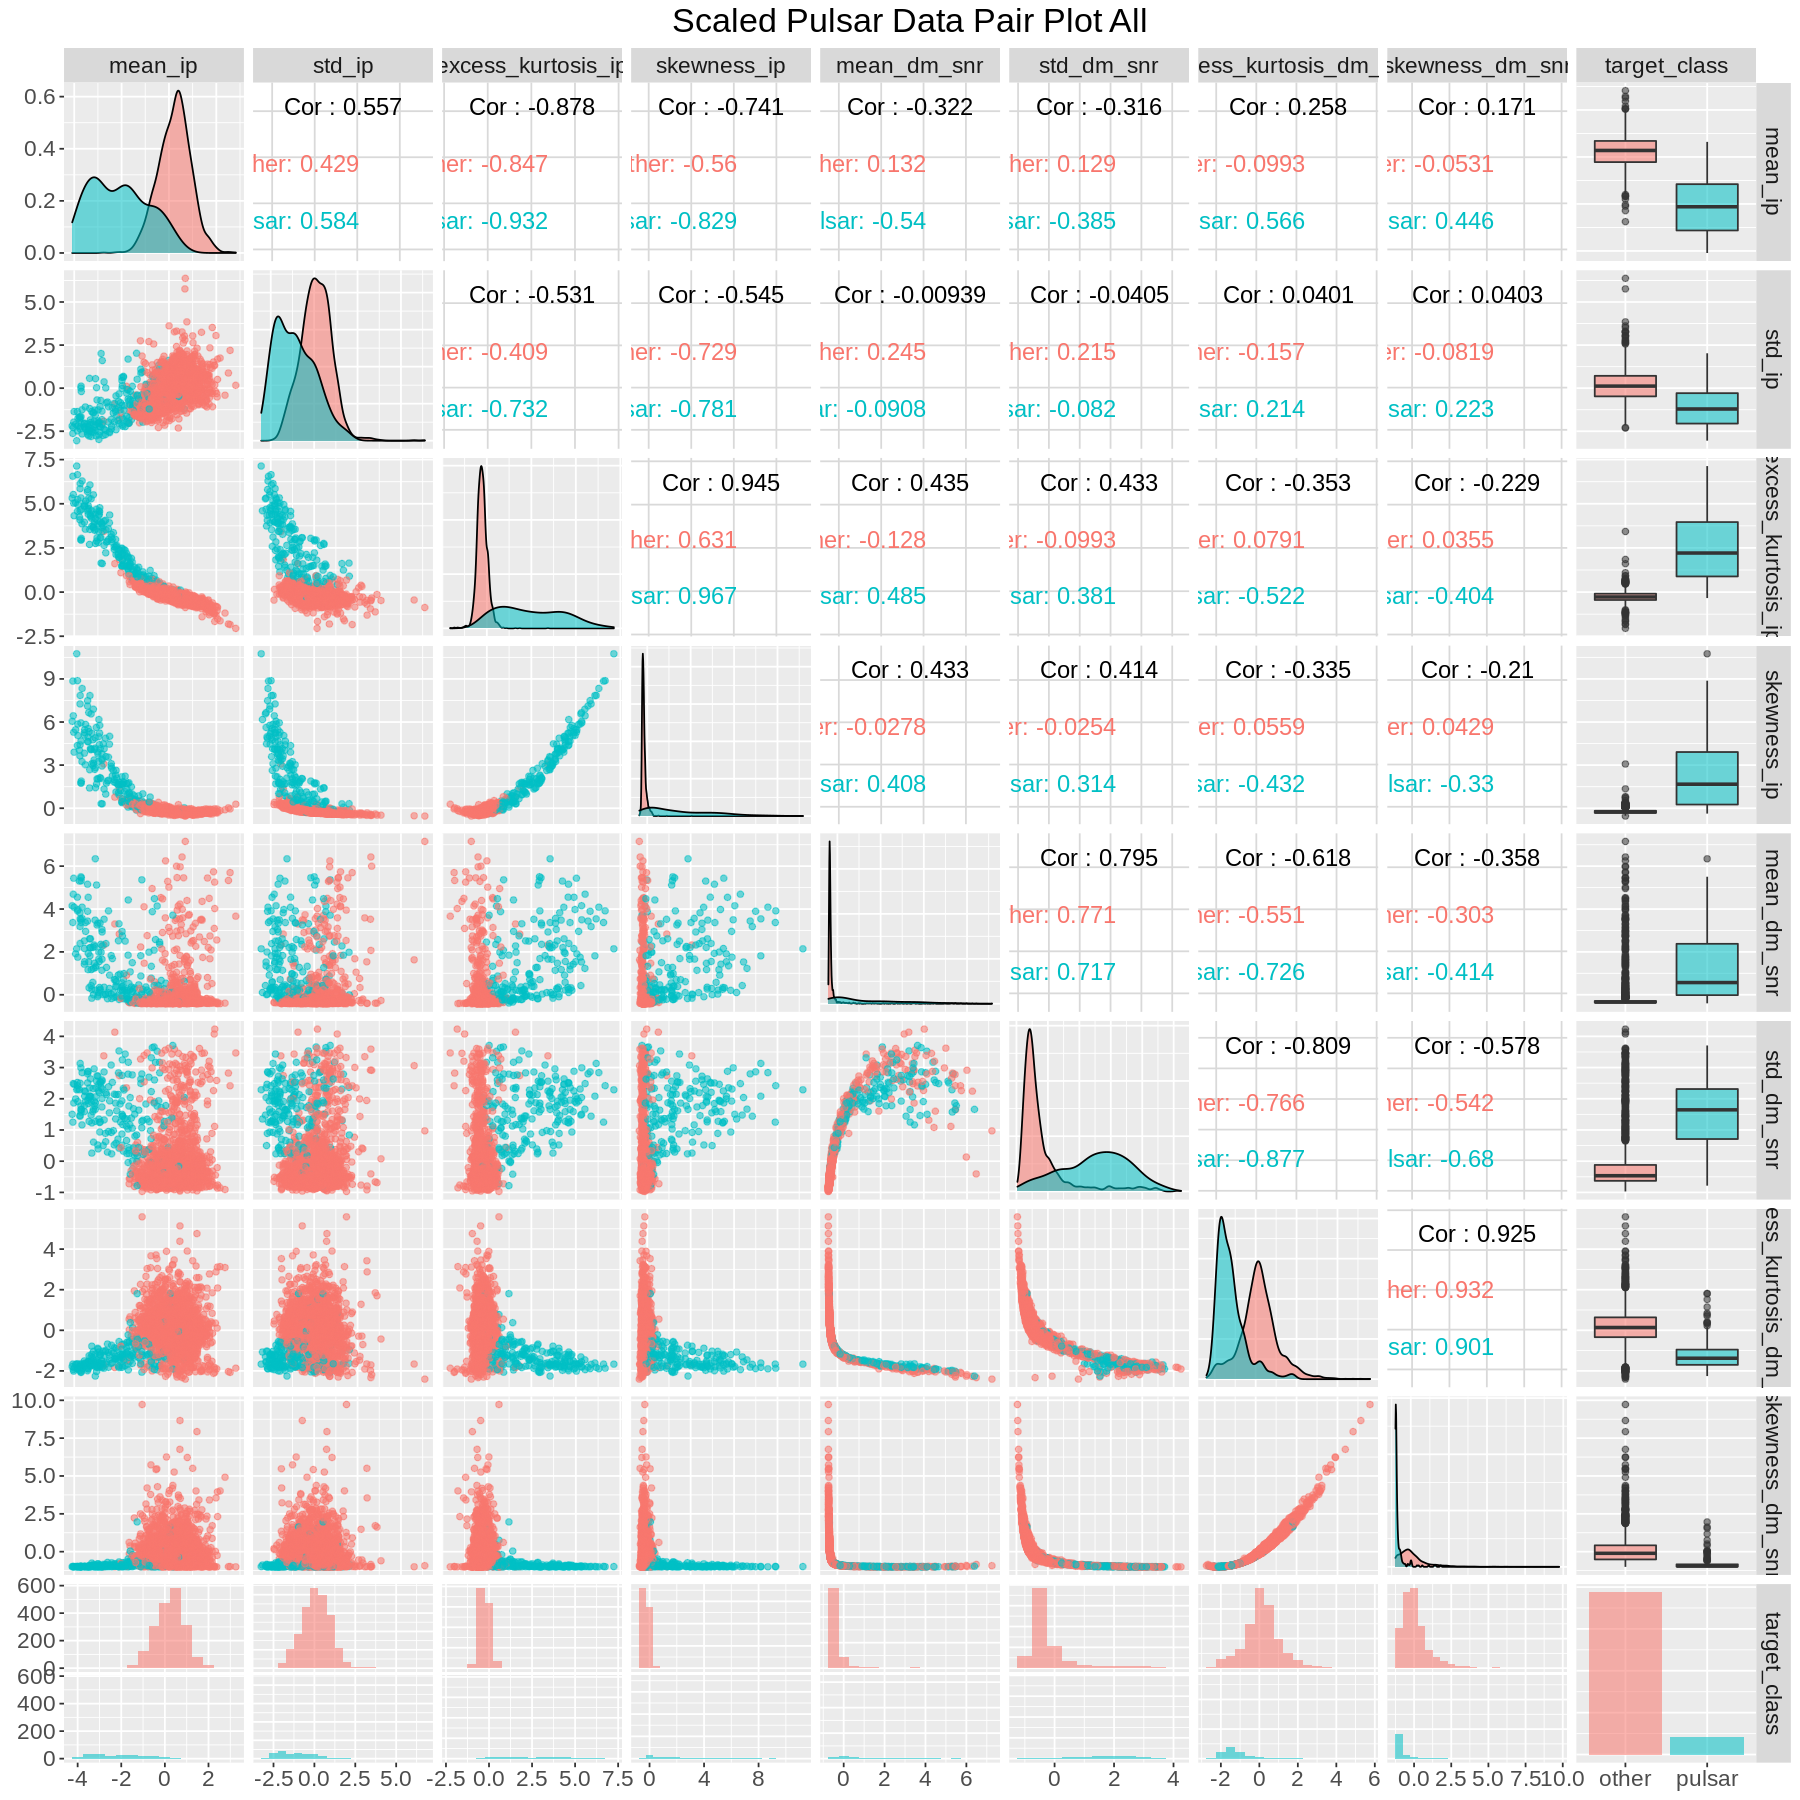

In [8]:
options(repr.plot.width = 15, repr.plot.height = 15)
ggpairs(pulsar_scaled_all %>% sample_frac(0.15),
           mapping = aes(color=target_class, alpha = 0.3),
           lower=list(combo=wrap("facethist", binwidth=0.5)),
           upper=list(continuous = wrap("cor", size=5))) +
        ggtitle("Scaled Pulsar Data Pair Plot All") +
        theme(text = element_text(size = 17),
              plot.title = element_text(hjust = 0.5))

#### Playing around with other plots

Below this cell is scratch for playing with different plotting styles

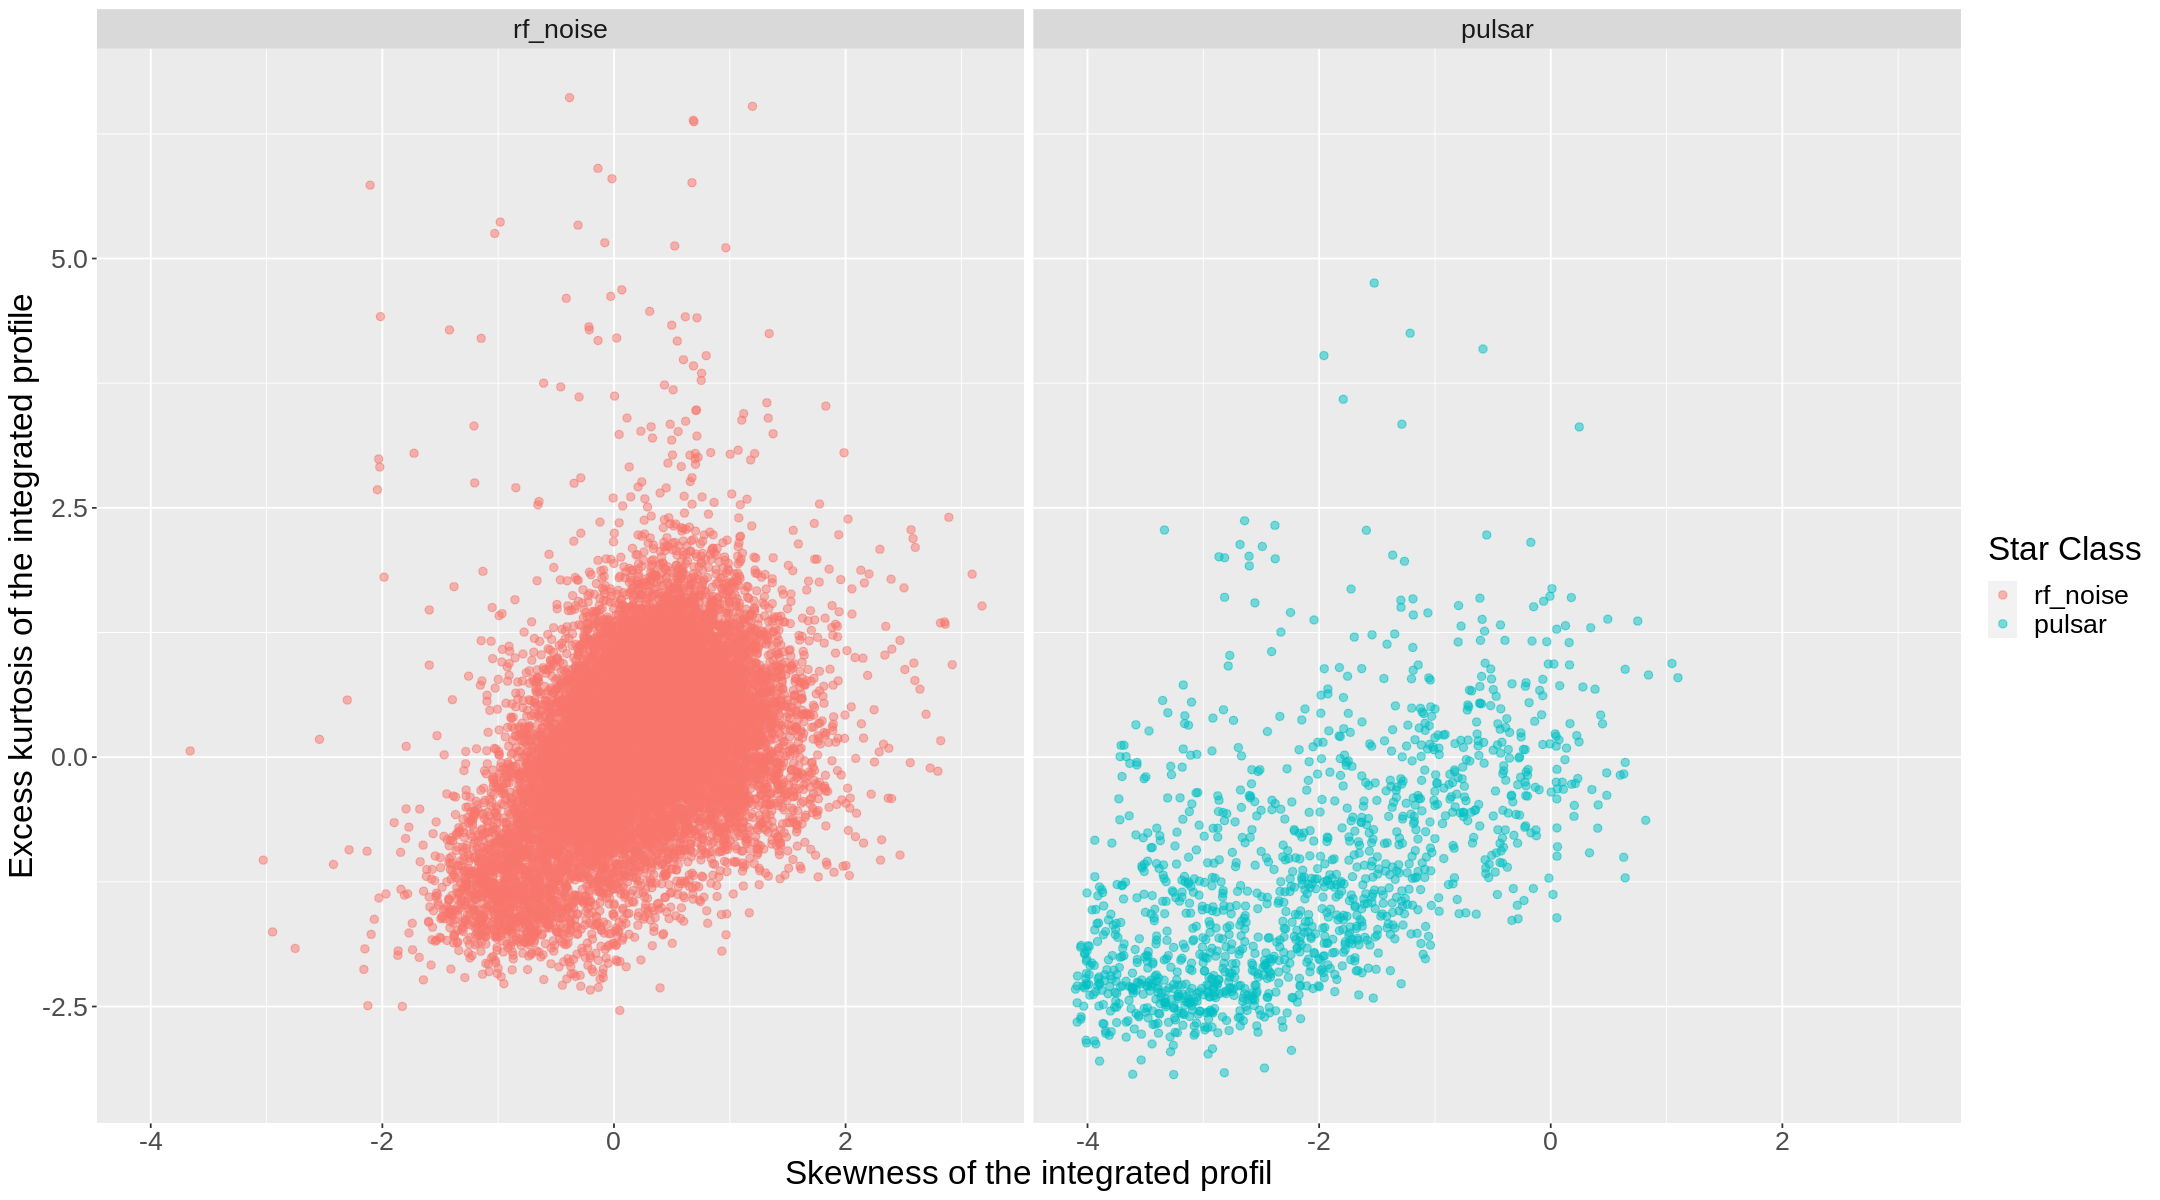

In [8]:
options(repr.plot.width = 18, repr.plot.height = 10)
pulsar_scaled_all %>% 
    ggplot(aes(x = mean_ip, y = std_ip, color = target_class)) + 
        geom_point(size = 2, alpha = 0.5) +
        labs(x = "Skewness of the integrated profil",
             y = "Excess kurtosis of the integrated profile",
             color = "Star Class") +
        theme(text = element_text(size=20)) +
        facet_grid(. ~target_class)